<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Полносвязная-нейронная-сеть" data-toc-modified-id="Полносвязная-нейронная-сеть-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Полносвязная нейронная сеть</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Предыдущее-значение" data-toc-modified-id="Предыдущее-значение-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Предыдущее значение</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Полносвязная-нейронная-сеть" data-toc-modified-id="Полносвязная-нейронная-сеть-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Полносвязная нейронная сеть</a></span></li></ul></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from catboost.utils import eval_metric
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import adfuller

## Подготовка

In [59]:
df = pd.read_csv("/datasets/taxi.csv", parse_dates=[0], index_col=[0])

In [60]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Анализ

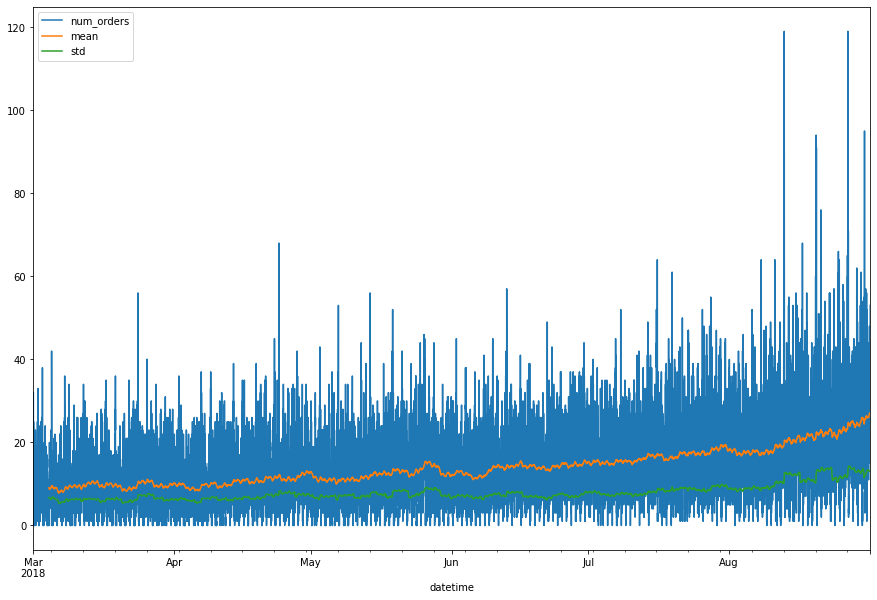

In [61]:
df["num_orders"].plot(figsize=(15,10))
df["num_orders"].rolling(500).mean().plot()
df["num_orders"].rolling(500).std().plot()
plt.legend(['num_orders', 'mean', 'std']);

Наблюдается недельная сезонность.

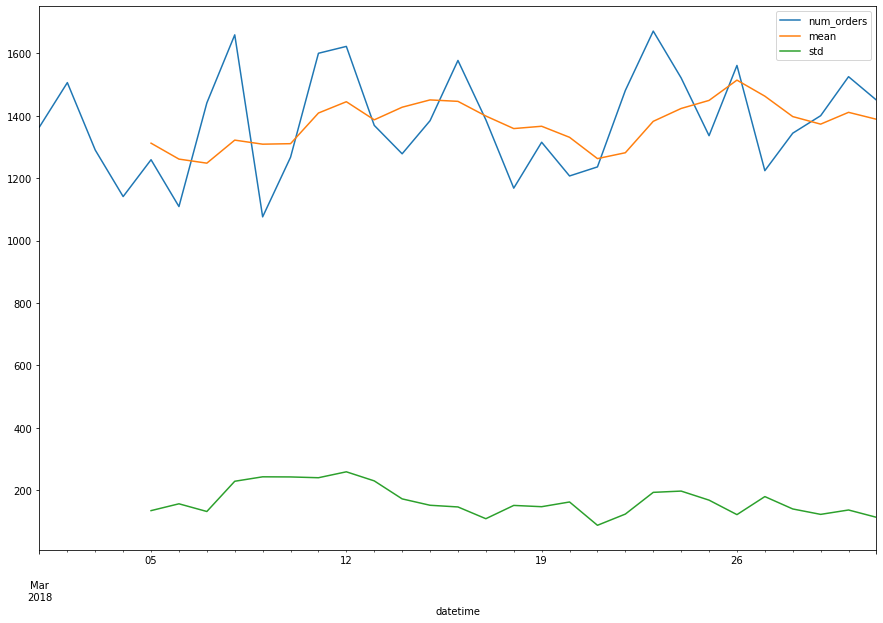

In [62]:
df.resample('1D').sum().loc["2018-03-01":"2018-03-31","num_orders"].plot(figsize=(15,10))
df.resample('1D').sum().loc["2018-03-01":"2018-03-31","num_orders"].rolling(5).mean().plot()
df.resample('1D').sum().loc["2018-03-01":"2018-03-31","num_orders"].rolling(5).std().plot()
plt.legend(['num_orders', 'mean', 'std']);

Наблюдается суточная сезонность. Пики заказов достигаются в полночь.

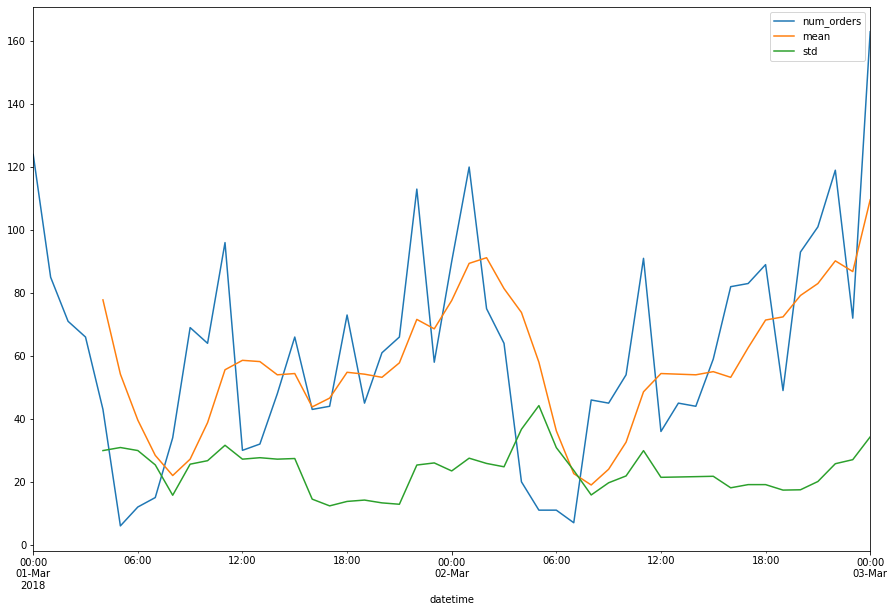

In [63]:
df.resample('1H').sum().loc["2018-03-01 00:00":"2018-03-03 00:00","num_orders"].plot(figsize=(15,10))
df.resample('1H').sum().loc["2018-03-01 00:00":"2018-03-03 00:00","num_orders"].rolling(5).mean().plot()
df.resample('1H').sum().loc["2018-03-01 00:00":"2018-03-03 00:00","num_orders"].rolling(5).std().plot()
plt.legend(['num_orders', 'mean', 'std']);

H0 - исходный временной ряд - нестационарный
H1 - исходный временной ряд стационарный

Для проверки нулевой гипотезы используется тест Дики-Фуллера.

In [64]:
f"pvalue = {adfuller(df)[1]}"

'pvalue = 2.2286378815479297e-23'

Значение pvalue много меньше доверительного интервала в 0.05, следует отвергнуть нулевую гипотезу и принять, что ряд является стационарным.

Добавление полей **day_of_week**, **rol**, **hour**, **lag_n** из исходной даты для обучения:

In [65]:
df = df.resample('1H').sum()
df["hour"] = df.index.hour
df["day_of_week"] = df.index.day_of_week
df['rol'] = df["num_orders"].shift().rolling(5).mean()
for i in range(1,15):
    df[f'lag_{i}'] = df["num_orders"].shift(i)
df.dropna(inplace=True)
df.head()

,num_orders,hour,day_of_week,rol,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 14:00:00,48,14,3,58.2,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 15:00:00,66,15,3,54.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 16:00:00,43,16,3,54.4,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 17:00:00,44,17,3,43.8,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 18:00:00,73,18,3,46.6,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


## Обучение

In [66]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(columns="num_orders")
targets_train = train["num_orders"]
features_test = test.drop(columns="num_orders")
targets_test = test["num_orders"]

### Catboost

In [67]:
cv_dataset = Pool(data=features_train,
                  label=targets_train)

In [68]:
for iter, depth, lr in [[100, 4, 0.1],[500, 5,0.05]]:
    params = {"iterations": iter,
            "depth": depth,
            "loss_function": "RMSE",
            "learning_rate": lr,
            "verbose": iter // 10}

    scores = cv(cv_dataset,
              params,
              folds = TimeSeriesSplit(n_splits=10)
                )

Training on fold [0/10]
0:	learn: 58.3980926	test: 60.6045366	best: 60.6045366 (0)	total: 1.12ms	remaining: 111ms
10:	learn: 30.8469159	test: 33.9244446	best: 33.9244446 (10)	total: 8.72ms	remaining: 70.5ms
20:	learn: 21.9319097	test: 25.5354849	best: 25.5354849 (20)	total: 15.4ms	remaining: 57.8ms
30:	learn: 19.1145230	test: 23.1653766	best: 23.1653766 (30)	total: 22ms	remaining: 48.9ms
40:	learn: 16.9999354	test: 21.7781612	best: 21.7781612 (40)	total: 28.3ms	remaining: 40.7ms
50:	learn: 15.8896749	test: 21.1452569	best: 21.1452569 (50)	total: 34.9ms	remaining: 33.5ms
60:	learn: 14.9711757	test: 20.6998337	best: 20.6998337 (60)	total: 41.4ms	remaining: 26.5ms
70:	learn: 14.1628477	test: 20.4937029	best: 20.4937029 (70)	total: 47.9ms	remaining: 19.6ms
80:	learn: 13.4153314	test: 20.5036905	best: 20.4471730 (77)	total: 54.3ms	remaining: 12.7ms
90:	learn: 12.8547871	test: 20.4883748	best: 20.4471730 (77)	total: 60.7ms	remaining: 6ms
99:	learn: 12.3478469	test: 20.4442334	best: 20.420341

### Случайный лес

In [69]:
model = RandomForestRegressor(random_state=12345)

grid_space={'max_depth':[10, 20],
              'n_estimators':[100, 200],
           }
grid = GridSearchCV(model,param_grid=grid_space,cv=TimeSeriesSplit(n_splits=10),scoring='neg_root_mean_squared_error')
model_grid = grid.fit(features_train, targets_train)
display(f'Best hyperparameters are: {model_grid.best_params_}')
display(f'Best estimator is: {model_grid.best_estimator_}')
display(f'Best score is: {model_grid.best_score_}')

"Best hyperparameters are: {'max_depth': 20, 'n_estimators': 100}"

'Best estimator is: RandomForestRegressor(max_depth=20, random_state=12345)'

'Best score is: -24.099143608396624'

### Полносвязная нейронная сеть

In [70]:
model = MLPRegressor(random_state=12345)

grid_space={'hidden_layer_sizes':[(16, 16, 16), (8, 8, 8)],
              'learning_rate_init':[0.01, 0.1],
            "max_iter": [100, 200]
           }
grid = GridSearchCV(model,param_grid=grid_space,cv=TimeSeriesSplit(n_splits=10),scoring='neg_root_mean_squared_error')
model_grid = grid.fit(features_train, targets_train)
display(f'Best hyperparameters are: {model_grid.best_params_}')
display(f'Best estimator is: {model_grid.best_estimator_}')
display(f'Best score is: {model_grid.best_score_}')

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

"Best hyperparameters are: {'hidden_layer_sizes': (16, 16, 16), 'learning_rate_init': 0.01, 'max_iter': 100}"

'Best estimator is: MLPRegressor(hidden_layer_sizes=(16, 16, 16), learning_rate_init=0.01,\n             max_iter=100, random_state=12345)'

'Best score is: -28.760113466501128'

## Тестирование

### Предыдущее значение

In [71]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
f"RMSE = {mean_squared_error(targets_test, pred_previous, squared=False)}"

'RMSE = 58.91761802963282'

### Линейная регрессия

In [72]:
model = LinearRegression()

In [73]:
model.fit(features_train, targets_train)

f"RMSE = {mean_squared_error(targets_test, model.predict(features_test), squared=False)}" 

'RMSE = 52.576527438598745'

### Catboost

In [74]:
model = CatBoostRegressor(iterations=500,
                           depth=10,
                           learning_rate=0.01,
                           loss_function='RMSE',
                           verbose=100)

In [75]:
model.fit(cv_dataset);

0:	learn: 38.4773817	total: 35.1ms	remaining: 17.5s
100:	learn: 27.0904277	total: 2.89s	remaining: 11.4s
200:	learn: 22.6990583	total: 5.77s	remaining: 8.58s
300:	learn: 20.6279098	total: 8.65s	remaining: 5.72s
400:	learn: 19.5092981	total: 11.3s	remaining: 2.8s
499:	learn: 18.7186551	total: 14s	remaining: 0us


In [76]:
preds = model.predict(features_test)

In [77]:
f"RMSE = {mean_squared_error(targets_test, preds, squared=False)}"

'RMSE = 51.21390972263209'

### Случайный лес

In [78]:
model = RandomForestRegressor(random_state=12345, max_depth=20, n_estimators=200)

In [79]:
model.fit(features_train, targets_train);

In [80]:
preds = model.predict(features_test)

In [81]:
f"RMSE = {mean_squared_error(targets_test, preds, squared=False)}"

'RMSE = 45.939176673745635'

### Полносвязная нейронная сеть

In [82]:
model = MLPRegressor(random_state=12345, hidden_layer_sizes=(16,16,16), learning_rate_init=0.01, max_iter=500)
model.fit(features_train, targets_train)
f"RMSE тестовой выборки: {mean_squared_error(targets_test, model.predict(features_test), squared=False)}" 

'RMSE тестовой выборки: 47.69129871933045'

Результаты тестирования: все модели проверку на адекватность. Лучший показатель RMSE достигается моделью линейной регрессии.

## Итоги

- Была выявлена нестационарность исходного временного ряда
- Были сформированы тестовая и тренировочная выборка в соотношении 1:9, к исходному датасету добавлены поля: день недели, час, скоьзящее среднее и предыдущее значение
- Были успешно обучены модели: линейная регрессия, случайный лес, catboost regressor, полносвязная нейронная сеть
- Все модели протестированы и прошли проверку на адекватность, выбрана модель случайного леса, её RMSE составил 45.94